In [114]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline 

In [115]:
words = open('names.txt','r').read().splitlines()
words[:3]

['emma', 'olivia', 'ava']

In [116]:
len(words)

32033

In [117]:
chars = sorted(list(set(''.join(words))))
s_to_i = {s:i+1 for i, s in enumerate(chars)}
s_to_i['.'] = 0 
i_to_s = {i:s for s,i in s_to_i.items()}
vocab_size = len(i_to_s)
print(i_to_s)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [118]:
block_size = 3
def build_dataset(words):
    X,Y = [],[]
    for w in words:
        context = [0]*block_size
        for ch in w + '.':
            ix = s_to_i[ch]
            X.append(context)
            Y.append(ix) 
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    # print(X)
    # print(Y)
    print(X.shape, Y.shape)
    return X,Y

import random 
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [119]:
n_embedding = 10
n_hidden = 200

g = torch.Generator().manual_seed(12123123123)
C = torch.randn((vocab_size, n_embedding), generator = g)
W1 = torch.rand((n_embedding * block_size, n_hidden), generator = g)
b1 = torch.rand(n_hidden, generator = g)
W2 = torch.rand((n_hidden, vocab_size), generator = g)
b2 = torch.rand(vocab_size, generator = g)

In [120]:
C.shape

torch.Size([27, 10])

In [121]:
W1.shape

torch.Size([30, 200])

In [122]:
b1.shape

torch.Size([200])

In [123]:
W2.shape

torch.Size([200, 27])

In [124]:
b2.shape

torch.Size([27])

In [125]:
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [126]:
max_steps = 1000000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator = g)
    Xb, Yb = X_train[ix], Y_train[ix]

    embedding = C[Xb]
    embedding_concatenate = embedding.view(embedding.shape[0], -1)
    layer1 = embedding_concatenate @ W1 + b1
    output1 = torch.tanh(layer1)
    layer2 = output1 @ W2 + b2
    loss = F.cross_entropy(layer2, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad


    if i%100000 == 0: 
        print(f'{i:7d}/{max_steps:7d} : {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/1000000 : 7.5113
 100000/1000000 : 1.9570
 200000/1000000 : 2.2263
 300000/1000000 : 1.4602
 400000/1000000 : 1.9159
 500000/1000000 : 1.7142
 600000/1000000 : 2.2546
 700000/1000000 : 1.9592
 800000/1000000 : 1.8666
 900000/1000000 : 2.1305


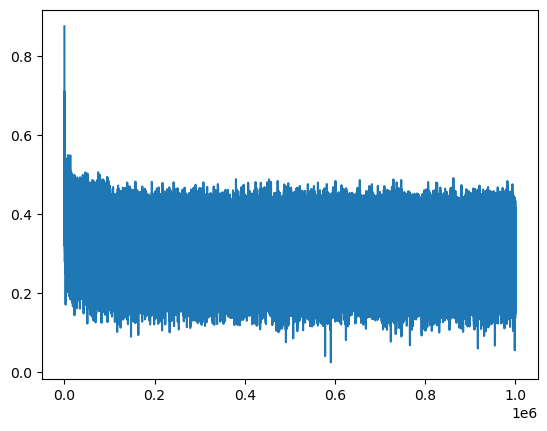

In [127]:
plt.plot(lossi)

In [128]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (X_train, Y_train),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test),
    }[split]
    emb = C[x]
    emb_cat = emb.view(emb.shape[0],-1)
    h = torch.tanh(emb_cat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 2.0283453464508057
val 2.110610008239746
test 2.1117875576019287


In [129]:
g = torch.Generator().manual_seed(12123123123)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 +b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator = g).item()
        context = context[1:]+[ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(i_to_s[i] for i in out))

fadian.
aadry.
carlon.
matily.
mairrashloraidece.
kai.
jael.
tymin.
nia.
kameen.
val.
elleif.
anishaashryn.
raya.
marionna.
kham.
rolber.
livianaalen.
alie.
thersalluwalynn.


In [130]:
# If we initalise the weights and bias with a minimum value but not zero and not same, then we can decrease the loss at the initialization  

In [131]:
# Steps to reduce loss 
# 1. Initial Loss
# 2. Apply softmax activation 
# 3. Apply tanh activation function to the initialisation layer
# 4. Use semi principled kaiming init instead of hacky init
#     Kaiming initialization method is calculated as a random number with a Gaussian probability 
#     distribution (G) with a mean of 0.0 and a standard deviation of sqrt(2/n), where n is the 
#     number of inputs to the node.
# 5. Add a batch normalisation layer
# So the pattern go like this Convolution -> Batch Norm -> ReLU

In [146]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(12123123123) # for reproducibility
C  = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

# BatchNorm parameters
batchnorm_gain = torch.ones((1, n_hidden))
batchnorm_bias = torch.zeros((1, n_hidden))
batchnorm_mean_running = torch.zeros((1, n_hidden))
batchnorm_std_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, batchnorm_gain, batchnorm_bias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [147]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
  Xb, Yb = X_train[ix], Y_train[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  emb_cat = emb.view(emb.shape[0], -1) 
  # Linear layer
  layer1 = emb_cat @ W1 
  # BatchNorm layer
  # -------------------------------------------------------------
  batchnorm_meani = layer1.mean(0, keepdim=True)
  batchnorm_stdi = layer1.std(0, keepdim=True)
  layer1 = batchnorm_gain * (layer1 - batchnorm_meani) / batchnorm_stdi + batchnorm_bias
  with torch.no_grad():
    batchnorm_mean_running = 0.999 * batchnorm_mean_running + 0.001 * batchnorm_meani
    batchnorm_std_running = 0.999 * batchnorm_std_running + 0.001 * batchnorm_stdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(layer1) # hidden layer
  layer2 = h @ W2 + b2 # output layer
  loss = F.cross_entropy(layer2, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.3025
  10000/ 200000: 2.3742
  20000/ 200000: 2.2123
  30000/ 200000: 2.0593
  40000/ 200000: 2.5664
  50000/ 200000: 2.1218
  60000/ 200000: 2.2079
  70000/ 200000: 2.2041
  80000/ 200000: 2.6559
  90000/ 200000: 2.1658
 100000/ 200000: 2.0586
 110000/ 200000: 2.1087
 120000/ 200000: 1.9835
 130000/ 200000: 2.3007
 140000/ 200000: 2.2375
 150000/ 200000: 1.8801
 160000/ 200000: 2.5452
 170000/ 200000: 2.0259
 180000/ 200000: 2.0578
 190000/ 200000: 2.3532


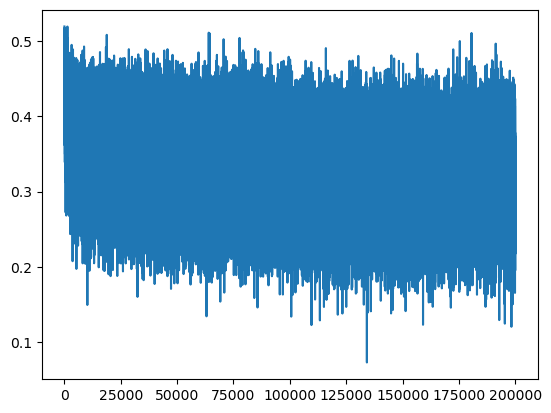

In [148]:
plt.plot(lossi)

In [149]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (X_train, Y_train),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test),
    }[split]
    emb = C[x]
    emb_cat = emb.view(emb.shape[0],-1)
    h = torch.tanh(emb_cat @ W1 + b1)
    layer2 = h @ W2 + b2
    loss = F.cross_entropy(layer2, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 2.7368736267089844
val 2.7772510051727295
test 2.76987361907959


In [150]:
g = torch.Generator().manual_seed(12123123123)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 +b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator = g).item()
        context = context[1:]+[ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(i_to_s[i] for i in out))

fredadtonnadil.
avavimasim.
amuamrasquonaidah.
dabellaedad.
mandnixchmilendvalle.
kaifeahmiraashryahran.
amardis.
fransm.
rof.
zhregvontzavirelys.
athavsallukaryahumarance.
amust.
kamingtoneespncen.
khz.
vilandcazdismyah.
jamuhumustna.
auden.
eskelahilhikdshna.
aaz.
daf.
